Building on the tutorial at https://pyro.ai/examples/sir_hmc.html, the folks at Pyro created an additional interface for SIR modeling that compresses much of the info that that tutorial provided into a concrete interface for compartmental modeling. Below is that work, drawn from http://pyro.ai/examples/epi_intro.html


### Now attempting to use real world data 

In [111]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import pandas as pd
import torch
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist

%matplotlib inline
#assert pyro.__version__.startswith('1.5.0') # I have 1.5.1, hopefully not a problem to comment this out. 
torch.set_default_dtype(torch.double)  # Required for MCMC inference.
pyro.enable_validation(True)  # Always a good idea.
smoke_test = ('CI' in os.environ)

In [112]:
pyro.__version__

'1.5.1'

In [113]:
class SimpleSIRModel(CompartmentalModel):
    def __init__(self, population, recovery_time, data):
        compartments = ("S", "I")  # R is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)
        assert isinstance(recovery_time, float)
        assert recovery_time > 1
        self.recovery_time = recovery_time
        self.data = data

    def global_model(self):
        """
        samples global parameters and packs them into a single return value (here a tuple, but any structure is allowed). 
        The return value is available as the params argument to the other two methods.
        """
        tau = self.recovery_time
        R0 = pyro.sample("R0", dist.LogNormal(0., 1.))
        rho = pyro.sample("rho", dist.Beta(100, 100))
        return R0, tau, rho

    def initialize(self, params):
        """
        samples (or deterministically sets) initial values of time series,
        returning a dictionary mapping time series name to initial value.
        """
        # Start with a single infection.
        return {"S": self.population - 1, "I": 1}

    def transition(self, params, state, t):
        """
        inputs global params, the state at the previous time step, and the time index t (which may be a slice!). 
        It then samples flows and updates the state dict.
        """
        R0, tau, rho = params

        # Sample flows between compartments.
        S2I = pyro.sample("S2I_{}".format(t),
                          infection_dist(individual_rate=R0 / tau,
                                         num_susceptible=state["S"],
                                         num_infectious=state["I"],
                                         population=self.population))
        I2R = pyro.sample("I2R_{}".format(t),
                          binomial_dist(state["I"], 1 / tau))

        # Update compartments with flows.
        state["S"] = state["S"] - S2I
        state["I"] = state["I"] + S2I - I2R

        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample("obs_{}".format(t),
                    binomial_dist(S2I, rho),
                    obs=self.data[t] if t_is_observed else None)

## Generating Data

What if I don't want to do this? 

In [114]:
US_SIR =pd.read_csv('../dat/US_SIR.csv')

In [129]:
population = torch.tensor(US_SIR['S'].values).double()[0]
S = torch.tensor(US_SIR['S'].values).double()[:100]
I = torch.tensor(US_SIR['I'].values).double()[:100]
R = torch.tensor(US_SIR['R'].values).double()[:100]

S2I = torch.tensor(US_SIR['S2I'].values).double()[:100]
obs = torch.tensor(US_SIR['S2I'].values).double()[:100]
I2R = torch.tensor(US_SIR['I2R'].values).double()[:100]

In [130]:
real_data = collections.OrderedDict()
real_data['R0'] = synth_data['R0']
real_data['rho'] = synth_data['rho']
real_data['S'] = S
real_data['S2I'] = S2I
real_data['I2R'] = I2R
real_data['I'] = I
real_data['obs'] = obs

In [131]:
for key, value in sorted(real_data.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))
    

I.shape = (100,)
I2R.shape = (100,)
R0.shape = ()
S.shape = (100,)
S2I.shape = (100,)
obs.shape = (100,)
rho.shape = ()


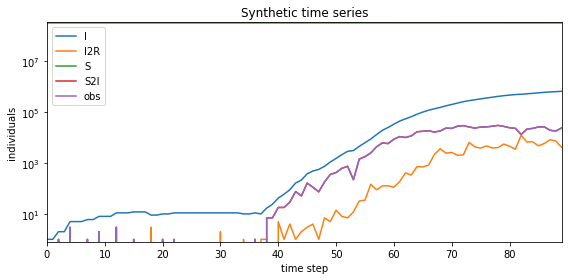

In [132]:
plt.figure(figsize=(8,4))
for name, value in sorted(real_data.items()):
    if value.dim():
        plt.plot(value, label=name)
plt.xlim(0, len(empty_data) - 1)
plt.ylim(0.8, None)
plt.xlabel("time step")
plt.ylabel("individuals")
plt.yscale("log")
plt.legend(loc="best")
plt.title("Synthetic time series")
plt.tight_layout()

## Inference

In [133]:
# what if we only have obs? can we estimate using just that? 
obs = real_data["obs"]
population = 329064930
recovery_time = 7.
model = SimpleSIRModel(population, recovery_time, obs) 


In [134]:
mcmc = model.fit_mcmc(num_samples=4 if smoke_test else 800,
                      jit_compile=True,)

INFO 	 Running inference...
Sample: 100%|██████████| 1600/1600 [01:25, 18.63it/s, step size=4.36e-05, acc. prob=0.907]


In [137]:
def plot_forecast(samples):
    duration = 100
    forecast = samples["S"].size(-1) - duration
    num_samples = len(samples["R0"])

    time = torch.arange(duration + forecast)
    S2I = samples["S2I"]
    median = S2I.median(dim=0).values
    p05 = S2I.kthvalue(int(round(0.5 + 0.05 * num_samples)), dim=0).values
    p95 = S2I.kthvalue(int(round(0.5 + 0.95 * num_samples)), dim=0).values

    plt.figure(figsize=(8, 4))
    plt.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
    plt.plot(time, median, "r-", label="median")
    plt.plot(time[:duration], obs, "k.", label="observed")
    plt.plot(time[:duration], real_data["S2I"], "k--", label="truth")
    plt.axvline(duration - 0.5, color="gray", lw=1)
    plt.xlim(0, len(time) - 1)
    plt.ylim(0, None)
    plt.xlabel("day after first infection")
    plt.ylabel("new infections per day")
    plt.title("New infections in population of {}".format(population))
    plt.legend(loc="upper left")
    plt.tight_layout()


INFO 	 Predicting latent variables for 100 time steps...
INFO 	 Forecasting 30 steps ahead...


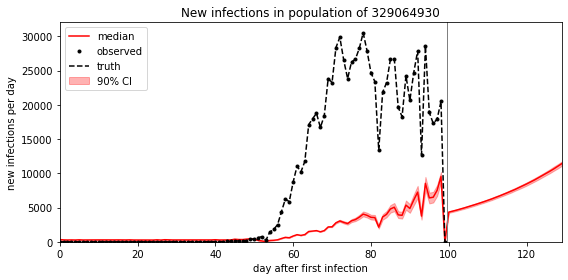

In [138]:
samples = model.predict(forecast=30)
plot_forecast(samples)

In [139]:
samples = model.predict()

INFO 	 Predicting latent variables for 100 time steps...


/home/nsk367/anaconda3/envs/pyro/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nsk367/anaconda3/envs/pyro/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


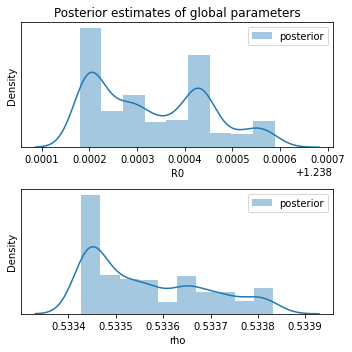

In [140]:
names = ["R0", "rho"]
fig, axes = plt.subplots(2, 1, figsize=(5, 5))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
   # truth = synth_data[name]
    sns.distplot(samples[name], ax=ax, label="posterior")
  #  ax.axvline(truth, color="k", label="truth")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
plt.tight_layout()